# 한국어 형태소 분석 및 데이터 시각화

이 노트북은 Bareun API를 사용하여 한국어 텍스트 데이터에서 명사를 추출하고, 다양한 시각화 기법을 통해 분석하는 방법을 설명합니다.

## 주요 기능
1. Bareun API를 사용한 한국어 형태소 분석
2. 뉴스 데이터에서 명사 추출
3. 워드클라우드, 네트워크 분석, 막대 차트를 통한 시각화

In [ ]:
# Bareun API 패키지 다운로드
# curl 명령을 사용해 Bareun Linux 패키지를 다운로드
# -L: 리다이렉션을 따름, -J: Content-Disposition 헤더 존재 시 파일명 사용, -k: SSL 인증 검증 무시, -s: 진행 상황 표시 없음
!curl -LJks -H "uname:$(uname -a)" https://bareun.ai/api/get -o bareun-linux.deb

# 현재 디렉토리의 파일 목록 표시
!ls

In [ ]:
# 시스템 정보 출력
# uname -a: 운영체제 이름, 호스트명, 커널 버전 등의 시스템 정보 출력
!uname -a

In [ ]:
# 다운로드한 Bareun 패키지 설치
# dpkg -i: 데비안 패키지 설치
!dpkg -i bareun-linux.deb

In [ ]:
# Bareun 환경 변수 설정
# %env: Jupyter 매직 명령어로 환경 변수 설정
%env BAREUN_ROOT="/opt/bareun"  # Bareun 설치 루트 경로 설정
%env LD_LIBRARY_PATH="/opt/bareun/lib"  # 라이브러리 경로 설정

# Bareun 서비스 백그라운드로 실행
# nohup: 로그아웃 후에도 명령이 계속 실행되도록 함
# &: 명령을 백그라운드로 실행
!BAREUN_ROOT="/opt/bareun" LD_LIBRARY_PATH="/opt/bareun/lib" nohup /opt/bareun/bin/bareun&

In [ ]:
# Bareun 프로세스 실행 확인
# ps -ef: 모든 프로세스 상세 정보 출력
# grep bareun: bareun 문자열이 포함된 라인만 필터링
!ps -ef | grep bareun

In [ ]:
# API 키 등록
# -reg 옵션: API 키 등록
!BAREUN_ROOT="/opt/bareun" LD_LIBRARY_PATH="/opt/bareun/lib" /opt/bareun/bin/bareun -reg koba-YEVHS7Q-VDSUWIY-XCIS3OQ-LWD7WHA

In [ ]:
# Bareun Python 패키지(bareunpy) 설치 또는 업데이트
# -U: 이미 설치된 패키지를 최신 버전으로 업그레이드
!pip install -U bareunpy

In [1]:
# 필요한 라이브러리 임포트
import sys  # 시스템 관련 함수 및 변수 제공
import google.protobuf.text_format as tf  # 프로토콜 버퍼 텍스트 포맷 처리
from bareunpy import Tagger  # 형태소 분석기
from bareunpy import Tokenizer  # 토크나이저
from collections import defaultdict  # 기본값이 있는 딕셔너리

# Bareun API 초기화
API_KEY="koba-YEVHS7Q-VDSUWIY-XCIS3OQ-LWD7WHA"  # API 키 설정
tagger = Tagger(API_KEY, 'localhost', 5656)  # 형태소 분석기 객체 생성 (localhost:5656 서버에 연결)
tokenizer = Tokenizer(API_KEY, 'localhost', 5656)  # 토크나이저 객체 생성

In [2]:
# pandas 라이브러리 임포트 (데이터 처리)
import pandas as pd

# Excel 파일 불러오기
file_path = '교권_news.xlsx'  # 분석할 Excel 파일 경로

# DataFrame으로 Excel 파일 로드
# sheet_name=0: 첫 번째 시트 선택
df = pd.read_excel(file_path, sheet_name=0)

# 데이터 미리보기 출력
print("Excel file loaded successfully. Preview:")  # 성공 메시지
print(df.head())  # 처음 5개 행 출력

# 데이터프레임 기본 정보 출력
print("\nDataFrame info:")
print(f"Shape: {df.shape}")  # 행과 열의 수 (shape)
print(f"Columns: {df.columns.tolist()}")  # 컬럼명 목록

Excel file loaded successfully. Preview:
                                         제목  \
0                     [채희창칼럼] 날개 없이 추락하는 교권   
1  이재명 후보 '미래교육자치위원회' 공식 출범… 200명 넘는 전문가 집결   
2                        [교육논단] 교육 공약을 살펴보다   
3       [앵커 브리핑] 갈수록 추락하는 교권···공교육 회복은 어떻게?   
4                       비참한 교권, 누가 이렇게 만들었나   

                                                  본문  
0  늘어 교권 보호 없인 국가 발전 어려워 지난달 28일 부산의 한 초등학교에서 5학년...  
1  총장), 교권보호특위(김성근 전 교육부 학교혁신지원실장), 학부모소통특위(김유임 전...  
2  각종 제도와 장치를 통해서 교권과 학습권을 강화하여 교육 회복을 여는 것. 기초 학...  
3  2023년 서이초 사건 당시 전국의 교사들이 거리로 나와 ‘공교육 멈춤의 날’ 집회...  
4  교권은 오랫동안 학생과 학부모, 그리고 그 잘난 정치인들에게 셀 수도 없을 만큼 차...  

DataFrame info:
Shape: (100, 2)
Columns: ['제목', '본문']


In [6]:
# 제목/본문에서 명사 추출 함수 (한 글자 명사 제외)
def extract_nouns_from_texts(texts, tagger):
    all_nouns = []
    for text in texts:
        if not isinstance(text, str):
            continue
        nouns = tagger.tags([text]).nouns()
        nouns = [noun for noun in nouns if len(noun) > 1]  # 한 글자 명사 제외
        all_nouns.extend(nouns)
    return all_nouns

# 제목에서 명사 추출
title_texts = df['제목'].dropna().tolist()
title_nouns = extract_nouns_from_texts(title_texts, tagger)

# 본문에서 명사 추출
content_texts = df['본문'].dropna().tolist()
content_nouns = extract_nouns_from_texts(content_texts, tagger)

# 제목+본문 전체 명사 합치기
all_nouns = title_nouns + content_nouns

# 빈도수 집계
from collections import Counter
noun_counts = Counter(all_nouns)
top_nouns = noun_counts.most_common(20)

print("상위 20개 명사와 빈도:")
for noun, count in top_nouns:
    print(f"{noun}: {count}")

상위 20개 명사와 빈도:
교권: 178
교육: 127
보호: 77
교사: 73
후보: 41
침해: 41
학생: 41
학교: 29
교원: 28
활동: 28
강화: 26
공약: 25
스승: 25
위원회: 19
학부모: 19
현장: 18
지원: 18
이재명: 17
대선: 17
특위: 17


/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s

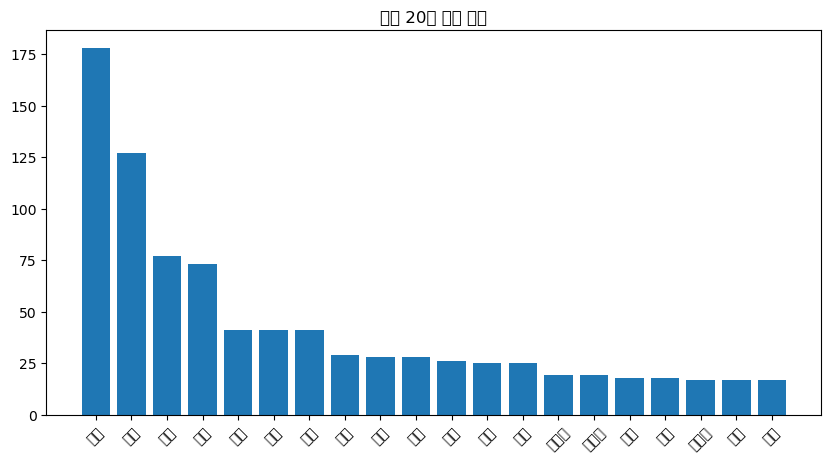

In [7]:
# 워드클라우드 시각화
'''
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(font_path='NanumGothic.ttf', width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dict(top_nouns))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
'''
import matplotlib.pyplot as plt
# 막대그래프 시각화
labels, values = zip(*top_nouns)
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title('상위 20개 명사 빈도')
plt.show()

/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45348 (\N{HANGUL SYLLABLE NE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/airman/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) De

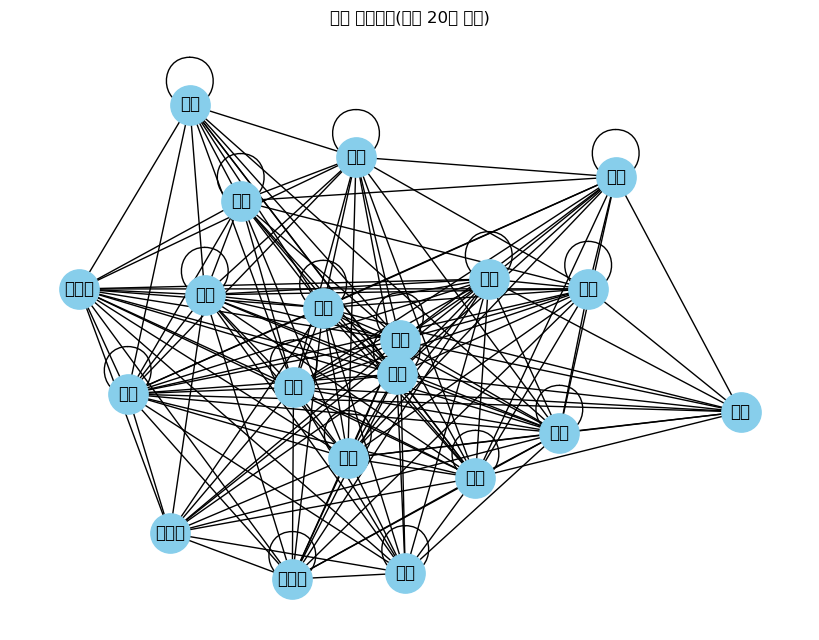

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict

# 1. 각 문서별 명사 리스트 만들기
doc_nouns = []
for idx, row in df.iterrows():
    title = row['제목']
    content = row['본문']
    nouns = []
    if isinstance(title, str):
        nouns += [n for n in tagger.tags([title]).nouns() if len(n) > 1]
    if isinstance(content, str):
        nouns += [n for n in tagger.tags([content]).nouns() if len(n) > 1]
    doc_nouns.append(nouns)

# 2. 상위 20개 명사만 사용
all_nouns = [n for nouns in doc_nouns for n in nouns]
top_nouns = set([n for n, _ in Counter(all_nouns).most_common(20)])

# 3. 동시 출현 카운트
co_occur = defaultdict(int)
for nouns in doc_nouns:
    filtered = [n for n in nouns if n in top_nouns]
    for i in range(len(filtered)):
        for j in range(i+1, len(filtered)):
            pair = tuple(sorted([filtered[i], filtered[j]]))
            co_occur[pair] += 1

# 4. 네트워크 생성 및 시각화
G = nx.Graph()
for (a, b), cnt in co_occur.items():
    if cnt >= 2:
        G.add_edge(a, b, weight=cnt)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=12)
plt.title('단어 네트워크(상위 20개 명사)')
plt.show()